In [210]:
import numpy as np
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix


In [2]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [3]:
strategy = tf.distribute.TPUStrategy(resolver)

In [43]:
df = pd.read_pickle('drive/MyDrive/data/audio_df.pkl')
df = df.loc[df["word_label"] != "zdanie", :].reset_index(drop=True)
df.head()

,word_label,person,mfcc,energy
0,aba,2_02,"[[-36.9777696349068, -25.61014598974831, -3.82...","[0.0007907406, 0.00065312884, 0.00068663375, 0..."
1,abe,2_02,"[[-43.79541135740947, -32.15604762490882, -9.5...","[0.00030584092, 0.00036026083, 0.000362127, 0...."
2,tablica,2_02,"[[-43.39532255479252, -31.838193908795898, -9....","[0.00040427153, 0.00041626877, 0.000385916, 0...."
3,zolc,2_02,"[[-38.79523653689342, -27.8312216897646, -7.01...","[0.00073661946, 0.0005053426, 0.0005301181, 0...."
4,dwa,2_02,"[[-29.296145467104644, -21.95215076813807, -8....","[0.003229658, 0.0036079595, 0.0021368014, 0.00..."


### Padding

In [44]:
max_len = 0
for i,val in enumerate(df["energy"]):
    this_len =  len(val)
    if this_len > max_len:
        # print(f"{i} : {this_len}")
        max_len = this_len 
        

In [111]:
df_padded = df.copy()
df_padded["mfcc"] = df_padded["mfcc"].apply(lambda x: np.pad(x, ((0, max_len - x.shape[0]), (0, 0)), mode='constant'))
df_padded["energy"] = df_padded["energy"].apply(lambda x: np.pad(x.reshape(-1,1), ((0, max_len - x.shape[0]), (0, 0)), mode='constant'))
df_padded["joined"] = df_padded[["mfcc","energy"]].apply(lambda x: np.hstack((x[0], x[1])),axis=1)

In [113]:
df_padded

,word_label,person,mfcc,energy,joined
0,aba,2_02,"[[-36.9777696349068, -25.61014598974831, -3.82...","[[0.0007907406], [0.00065312884], [0.000686633...","[[-36.9777696349068, -25.61014598974831, -3.82..."
1,abe,2_02,"[[-43.79541135740947, -32.15604762490882, -9.5...","[[0.00030584092], [0.00036026083], [0.00036212...","[[-43.79541135740947, -32.15604762490882, -9.5..."
2,tablica,2_02,"[[-43.39532255479252, -31.838193908795898, -9....","[[0.00040427153], [0.00041626877], [0.00038591...","[[-43.39532255479252, -31.838193908795898, -9...."
3,zolc,2_02,"[[-38.79523653689342, -27.8312216897646, -7.01...","[[0.00073661946], [0.0005053426], [0.000530118...","[[-38.79523653689342, -27.8312216897646, -7.01..."
4,dwa,2_02,"[[-29.296145467104644, -21.95215076813807, -8....","[[0.003229658], [0.0036079595], [0.0021368014]...","[[-29.296145467104644, -21.95215076813807, -8...."
...,...,...,...,...,...
2489,sombap,4_10,"[[-44.12073670856593, -31.363475325635754, -7....","[[0.00039042364], [0.00025011163], [0.00026692...","[[-44.12073670856593, -31.363475325635754, -7...."
2490,piecdziesieciogroszowka,4_10,"[[-44.086946238635875, -31.133380446525507, -6...","[[0.00022395096], [0.00016624904], [0.00069651...","[[-44.086946238635875, -31.133380446525507, -6..."
2491,kurowa,4_10,"[[-46.822342231115805, -33.577166927618514, -8...","[[0.00025195483], [0.00025225707], [0.00030315...","[[-46.822342231115805, -33.577166927618514, -8..."
2492,trzy,4_10,"[[-45.96352915037683, -33.16892054033775, -8.4...","[[0.00029977347], [0.00031788007], [0.00031162...","[[-45.96352915037683, -33.16892054033775, -8.4..."


---
Speaking person recognition

In [262]:
labels = df_padded["person"].unique()

In [263]:
unique_labels = sorted(set(labels))
label_map = {label: i for i, label in enumerate(unique_labels)}

In [265]:
X = df_padded["joined"]
y = df_padded["person"].map(label_map)


In [266]:
X_, X_val, y_, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42, stratify=y_)


In [172]:
input_shape = X_train[0].shape
input_shape

(1037, 17)

In [267]:
X_train = np.array(X_train.to_list())
X_test = np.array(X_test.to_list())
X_val = np.array(X_val.to_list())

In [203]:
with strategy.scope():
  model = tf.keras.Sequential([ 
      layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape),
      layers.MaxPooling1D(pool_size=2),
      layers.Conv1D(64, kernel_size=3, activation='relu'),
      layers.MaxPooling1D(pool_size=2),
      layers.Conv1D(128, kernel_size=3, activation='relu'),
      layers.GlobalAveragePooling1D(),
      layers.Dense(64, activation='relu'),
      layers.Dense(23, activation='softmax') 
  ])

  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  model.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 1035, 32)          1664      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 517, 32)          0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 515, 64)           6208      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 257, 64)          0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 255, 128)          24704     
                                                                 
 global_average_pooling1d_2   (None, 128)            

In [204]:
checkpoint_path = 'best_model.h5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)


In [205]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=16, callbacks=[checkpoint])


Epoch 1/100
112/113 [============================>.] - ETA: 0s - loss: 2.8965 - accuracy: 0.1077
Epoch 1: val_accuracy improved from -inf to 0.14699, saving model to best_model.h5
113/113 [==============================] - 10s 43ms/step - loss: 2.8952 - accuracy: 0.1081 - val_loss: 2.5532 - val_accuracy: 0.1470
Epoch 2/100
111/113 [============================>.] - ETA: 0s - loss: 2.2057 - accuracy: 0.3086
Epoch 2: val_accuracy improved from 0.14699 to 0.35635, saving model to best_model.h5
113/113 [==============================] - 4s 33ms/step - loss: 2.2024 - accuracy: 0.3103 - val_loss: 1.9785 - val_accuracy: 0.3563
Epoch 3/100
111/113 [============================>.] - ETA: 0s - loss: 1.7495 - accuracy: 0.4505
Epoch 3: val_accuracy improved from 0.35635 to 0.59243, saving model to best_model.h5
113/113 [==============================] - 4s 37ms/step - loss: 1.7474 - accuracy: 0.4501 - val_loss: 1.4003 - val_accuracy: 0.5924
Epoch 4/100
110/113 [============================>.] - ET

In [268]:
best_model = tf.keras.models.load_model("best_model.h5")

In [269]:
y_pred = best_model.predict(X_val)
y_pred = np.argmax(y_pred, axis=1) 

8/8 [==============================] - 0s 12ms/step


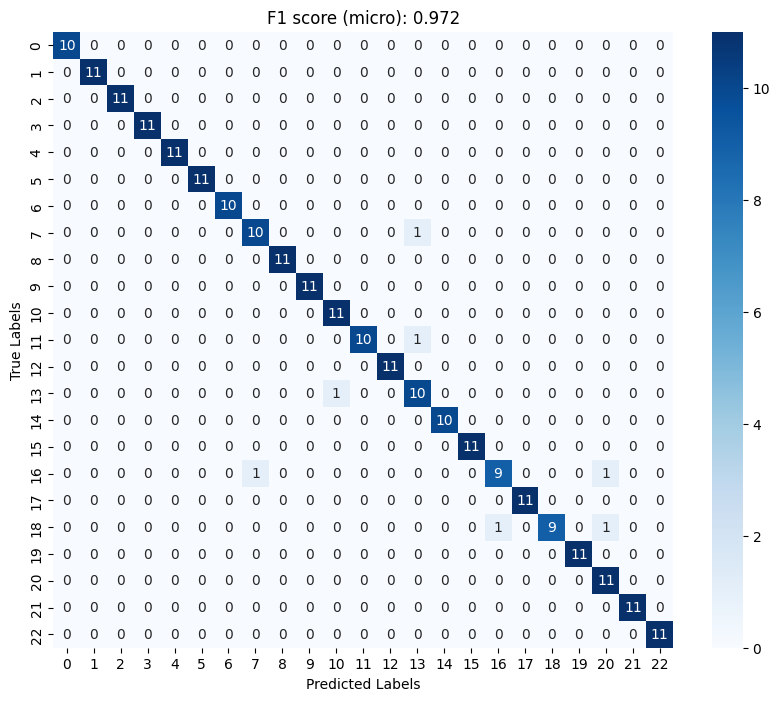

F1 score (micro): 0.972


In [270]:
f1_micro = f1_score(y_val, y_pred, average='micro')
confusion_mat = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title(f"F1 score (micro): {f1_micro}")
plt.show()

print("F1 score (micro):", f1_micro)

---
Numbers recognition

In [226]:
df_numbers = df_padded.query("word_label in ['zero','jeden', 'dwa', 'trzy', 'cztery', 'piec', 'szesc','siedem','osiem','dziewiec','dziesiec']")[["word_label","joined"]]


In [227]:
label_map = {
    'zero' : 0,
    'jeden': 1,
    'dwa': 2,
    'trzy': 3,
    'cztery': 4,
    'piec': 5,
    'szesc': 6,
    'siedem': 7,
    'osiem': 8,
    'dziewiec': 9,
    'dziesiec': 10
}

In [230]:
X = df_numbers["joined"]
y = df_numbers["word_label"].map(label_map)


In [231]:
X_, X_val, y_, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42, stratify=y_)


In [242]:
input_shape = X_train[2146].shape

In [243]:
X_train = np.array(X_train.to_list())
X_test = np.array(X_test.to_list())
X_val = np.array(X_val.to_list())


In [247]:
with strategy.scope():
  model_numbers = tf.keras.Sequential([ 
      layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape),
      layers.MaxPooling1D(pool_size=2),
      layers.Conv1D(64, kernel_size=3, activation='relu'),
      layers.MaxPooling1D(pool_size=2),
      layers.Conv1D(128, kernel_size=3, activation='relu'),
      layers.GlobalAveragePooling1D(),
      layers.Dense(64, activation='relu'),
      layers.Dense(11, activation='softmax') 
  ])

  model_numbers.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

  model_numbers.summary()


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 1035, 32)          1664      
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 517, 32)          0         
 1D)                                                             
                                                                 
 conv1d_13 (Conv1D)          (None, 515, 64)           6208      
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 257, 64)          0         
 1D)                                                             
                                                                 
 conv1d_14 (Conv1D)          (None, 255, 128)          24704     
                                                                 
 global_average_pooling1d_4   (None, 128)            

In [248]:
checkpoint_path = 'best_model_numbers.h5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)


In [249]:
model_numbers.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=16, callbacks=[checkpoint])


Epoch 1/100
32/32 [==============================] - ETA: 0s - loss: 2.4188 - accuracy: 0.1210
Epoch 1: val_accuracy improved from -inf to 0.17460, saving model to best_model_numbers.h5
32/32 [==============================] - 12s 164ms/step - loss: 2.4188 - accuracy: 0.1210 - val_loss: 2.3614 - val_accuracy: 0.1746
Epoch 2/100
30/32 [===========================>..] - ETA: 0s - loss: 2.2946 - accuracy: 0.1813
Epoch 2: val_accuracy did not improve from 0.17460
32/32 [==============================] - 1s 45ms/step - loss: 2.2871 - accuracy: 0.1825 - val_loss: 2.2147 - val_accuracy: 0.1746
Epoch 3/100
32/32 [==============================] - ETA: 0s - loss: 2.0704 - accuracy: 0.2401
Epoch 3: val_accuracy improved from 0.17460 to 0.37302, saving model to best_model_numbers.h5
32/32 [==============================] - 2s 72ms/step - loss: 2.0704 - accuracy: 0.2401 - val_loss: 1.9421 - val_accuracy: 0.3730
Epoch 4/100
32/32 [==============================] - ETA: 0s - loss: 1.7888 - accuracy:

In [250]:
best_model_numbers = tf.keras.models.load_model(checkpoint_path)

In [251]:
y_pred = best_model_numbers.predict(X_val)
y_pred = np.argmax(y_pred, axis=1) 

3/3 [==============================] - 0s 24ms/step


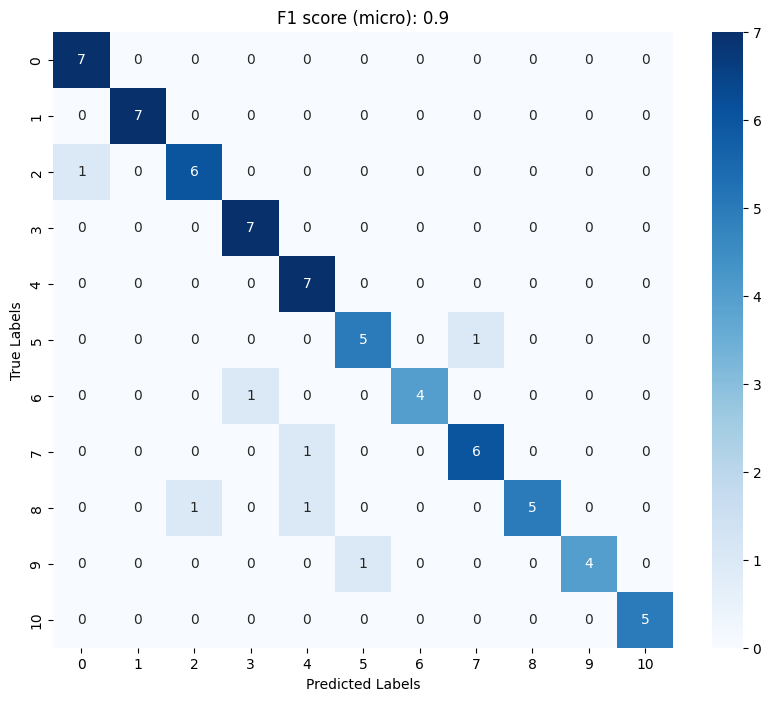

F1 score (micro): 0.9


In [253]:
f1_micro = f1_score(y_val, y_pred, average='micro')
confusion_mat = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title(f"F1 score (micro): {f1_micro}")
plt.show()
print("F1 score (micro):", f1_micro)